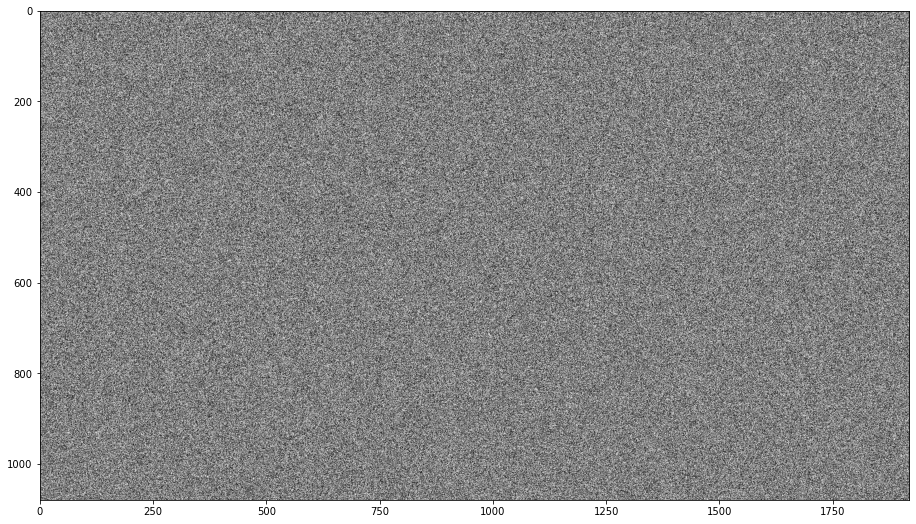

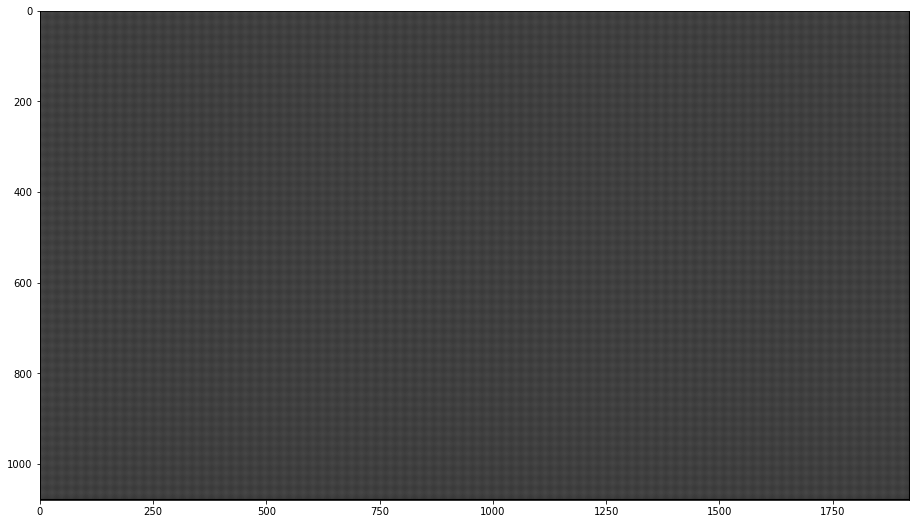

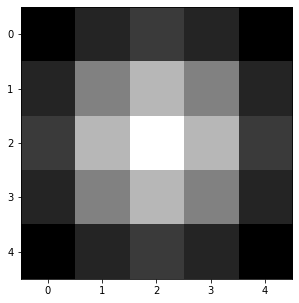

[[ 22  55  75  55  22]
 [ 55 139 188 139  55]
 [ 75 188 254 188  75]
 [ 55 139 188 139  55]
 [ 22  55  75  55  22]]


In [2]:
from concurrent.futures import ThreadPoolExecutor
from matplotlib import pyplot as plt
import scipy.stats as st
import numpy as np
import skimage.io
# import cythonized 
import time
import os

def generateKernel(size=3, sigma=3):
    x = np.linspace(-sigma, sigma, size+1)
    kern1d = np.diff(st.norm.cdf(x))
    kern2d = np.outer(kern1d, kern1d)
    return kern2d/kern2d.sum()

def format_result(times):
    suffix = ['nS', 'µS','mS','S']
    mean=np.mean(times)
    std=np.std(times)
    s1=int(np.log(mean) / np.log(1000))
    s2=int(np.log(std) / np.log(1000))
    if s1>3:
        s1=3
    if s2>3:
        s2=3
    mean /= 1000**s1
    std /= 1000**s2
    return ('%.2f%s ± %.1f%s per loop (%i runs)'%(mean, suffix[s1], std, suffix[s2], len(times)))

def bench(fn,nLoops,timeout=10,fmt=True):
    times = []
    initial = time.time()
    while len(times)<nLoops and time.time()-initial < timeout:
        start = time.time_ns()
        fn()
        end = time.time_ns()
        times.append(end-start)
    if fmt:
        return format_result(times)
    else:
        return (np.mean(times),np.std(times),len(times))     

size = 5
offset = size//2
w = 1920
h = 1080
benchmark = True

img = np.random.randint(256, size=(h, w)).astype('uint8')

kernel = np.zeros((2,2))
kernel[0,0]=1
partial = np.tile(kernel,((h//2)-offset,(w//2)-offset))
mask = np.zeros((h,w)).astype('uint8')
mask[offset:-offset,offset:-offset] = partial

plt.figure(figsize=(16,9))
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

plt.figure(figsize=(16,9))
plt.imshow(mask, cmap='gray', vmin=0, vmax=1)
plt.show()

kernel = (generateKernel(size=size,sigma=2))
kernel = (kernel*(255/np.max(kernel))).astype('uint8')
plt.figure(figsize=(size,size))
plt.imshow(kernel, cmap='gray')
plt.show()
print(kernel)

In [3]:
 extract = [np.nan, 2, 3 , np.nan]
 m = np.where(np.isnan(extract), 0, 1.0)
 print(m)

NameError: name 'nan' is not defined

In [2]:
indecies = np.where(mask[offset:-offset,offset:-offset]==1)
locations = np.vstack(indecies).T.astype('uint32')
nFields = len(locations)
print("Number of fields: %i"%nFields)

Number of fields: 515404


In [9]:
results = np.zeros(len(locations)).astype('uint32')

def multithread(n,locations_array,offset,img,kernel,results):
    with ThreadPoolExecutor(max_workers=n) as executor:
        jobs = [executor.submit(cythonized.multiply,locations_array[i], offset,img,kernel,results) for i in range(n)]
if benchmark:
    for i in range(os.cpu_count()):
        locations_array= np.array_split(locations,i+1)
        print("%i Threads: %s"%(i+1,bench(lambda:multithread(i+1,locations_array,offset,img,kernel,results),1000)))

1 Threads: 1.62S ± 50.0mS per loop (7 runs)
2 Threads: 820.77mS ± 33.8mS per loop (13 runs)
3 Threads: 563.21mS ± 10.3mS per loop (18 runs)
4 Threads: 483.08mS ± 131.3mS per loop (21 runs)
5 Threads: 405.33mS ± 112.5mS per loop (25 runs)
6 Threads: 375.34mS ± 123.4mS per loop (27 runs)
7 Threads: 379.07mS ± 81.6mS per loop (27 runs)
8 Threads: 354.16mS ± 98.7mS per loop (29 runs)


In [4]:
print(results)

[     29800      58988      90004 ... 2820570239 2820599877 2820630322]


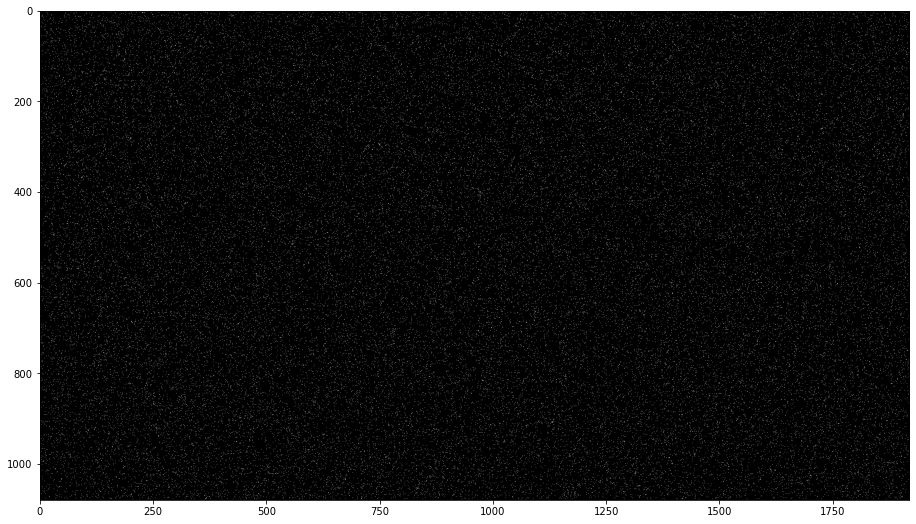

In [7]:
coords_set = set()
random_mask = mask = np.zeros((h,w)).astype('uint8')
while len(coords_set) < 500000:
    x = np.random.randint(offset,1920-offset)
    y = np.random.randint(offset,1080-offset)
    coords_set.add((x, y))
    random_mask[y,x]=1

plt.figure(figsize=(16,9))
plt.imshow(random_mask, cmap='gray', vmin=0, vmax=1)
plt.show()

In [8]:
nThreads = os.cpu_count()

results2 = np.zeros(len(locations)).astype('uint32')
random_indecies = np.where(random_mask[offset:-offset,offset:-offset]==1)
locs = np.vstack(random_indecies).T.astype('uint32')
locs_array = np.array_split(locs,nThreads)


start = time.time_ns()
multithread(nThreads,locs_array,offset,img,kernel,results2)
end = time.time_ns()

print("Number of fields: %i \n Time taken: %i mS"%(len(locs),(end-start)//(10**6)))
print(results2)

Number of fields: 50000 
 Time taken: 54 mS
[29480 62303 94489 ...     0     0     0]
